#Quick Point Source Scan analysis
Script that uses scape to reduce data consisting of scans across a point source.

Revision History:
* (Ruby) Initial version based on old KAT-7 analysis
* (Ruby) Get things working with differences between AR1 and RTS
* (Ruby/Sean) Add simple beam fit using pointing model calculations for single compscan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
import pickle
import katdal
import katpoint
import scape
import logging, os

from katsdpscripts.reduction.analyse_point_source_scans import reduce_and_plot
from katsdpscripts.reduction.analyse_point_source_scans import extract_cal_dataset,reduce_compscan

%matplotlib inline

#User Input

In [2]:
#KAT-7
#filename = '/var/kat/archive/data/comm/2015/08/05/1438762778.h5'
#antenna_name='ant2'
#k7=True

#AR1
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453892215.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453888819.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453887994.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453887206.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453885291.h5'
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453883060.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453882427.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453881720.h5'
#filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453874577.h5'
#filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453874854.h5'
#filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/26/1453830302.h5'
#filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/26/1453805362.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/06/1452601773.h5'
#filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/06/1452601273.h5'
#filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/12/1452605102.h5'
#antenna_name='m062'
antenna_name='m063'
k7=False


#Static Defaults

* Noise diode model names must be of the form ***antenna***.**coupler**.h.csv otherwise scape will say that it can't find them.
* Pointing model names must be in the form ***antenna***.**band**.pm.csv

In [3]:
# Default output file names are based on input file name
dataset_name = os.path.splitext(os.path.basename(filename))[0]
outfilebase = '%s_%s_point_source_scans' % (dataset_name,antenna_name)
# Default values for Ku-band need to be updated if data uses this band
ku_band=False
# Baseline to load (e.g. 'ant1' for antenna 1 or 'ant1,ant2' for 1-2 baseline),
# default is first single-dish baseline in file
baseline='sd'
# Range of frequency channels to keep (zero-based, specified as 'start,end', if None the default is 50% of the bandpass)
freq_chans=None
# Number of Monte Carlo iterations to estimate uncertainty (20-30 suggested, default off)
mc_iterations=20
# Time offset to add to DBE timestamps, in seconds
time_offset=0.0

In [4]:
# Optional pickle file with boolean array specifying channels to mask
channel_mask ='/var/kat/katsdpscripts/RTS/rfi_mask.pickle'

if k7:
    #KAT-7
    nd_models = '/var/kat/katconfig/user/noise-diode-models/'
    pt_models = '/var/kat/katconfig/user/pointing-models/'
else:
    #AR1
    # Name of directory containing noise diode model files
    nd_models = '/var/kat/katconfig/user/noise-diode-models/mkat/'
    # Name of the directory containing pointing model parameters
    pt_models = '/var/kat/katconfig/user/pointing-models/mkat/'

#Utility function
Build option container for reduce_and_plot

In [5]:
class Storage(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError, k:
            raise AttributeError, k

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError, k:
            raise AttributeError, k

    def __repr__(self):
        return '<Storage ' + dict.__repr__(self) + '>'

opts = Storage()
opts['baseline'] = baseline
opts['nd_models'] = nd_models
opts['channel_mask'] = channel_mask
opts['ku_band'] = ku_band
opts['batch'] = False
opts['keep_all'] = False
opts['mc_iterations'] = mc_iterations
opts['plot_spectrum'] = True
opts['freq_chans'] = freq_chans
opts['time_offset'] = time_offset
opts['pointing_model'] = pt_models
opts['outfilebase'] = outfilebase

#Processing Script

In [6]:
print ('Loading HDF5 file %s into scape and reducing the data'%filename)
h5file = katdal.open(filename)
# reduced version that deals with current bug in scape
if len(h5file.catalogue.targets) > 1:
    print ('Removing first dummy scan caused by premature noise diode fire')
    h5file.sensor.get('Observation/target_index').remove(1)
    s=h5file.sensor.get('Observation/target')
    s.remove(s.unique_values[0])
    h5file.catalogue.remove(h5file.catalogue.targets[0].name)

Loading HDF5 file /var/kat/archive/data/MeerKATAR1/telescope_products/2016/01/27/1453883060.h5 into scape and reducing the data


keep_all=False,main_compscan.beam.is_valid=True , keep=True 


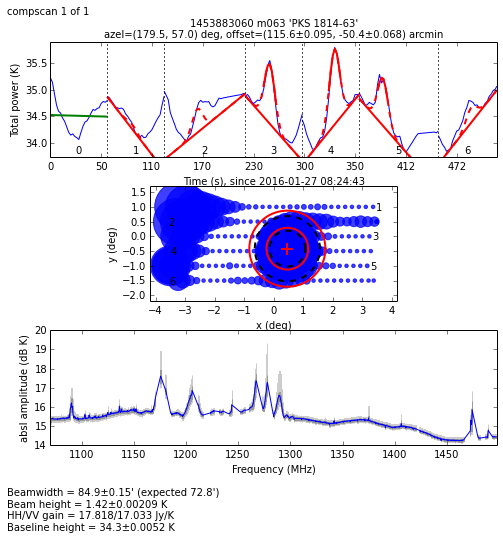

In [7]:
kwargs={}

#Force centre freqency if ku-band option is set
if ku_band: kwargs['centre_freq'] = 12.5005e9

# Produce canonical version of baseline string (remove duplicate antennas)
baseline_ants = baseline.split(',')
if len(baseline_ants) == 2 and baseline_ants[0] == baseline_ants[1]: baseline = baseline_ants[0]

# Load data set
if antenna_name not in [ant.name for ant in h5file.ants]:
    raise RuntimeError('Cannot find antenna %s in dataset'%antenna_name)
for pol in ['h','v']:
    noise_file=os.path.join(nd_models, '%s.coupler.%s.csv' % (antenna_name,pol))
    if not os.path.isfile(noise_file):
        raise RuntimeError('Cannot find file %s' %(noise_file))

h5file.select(ants=antenna_name)
ant = h5file.ants[0]
dataset = scape.DataSet(h5file, baseline="%s" % (ant.name,), nd_models=nd_models, time_offset=time_offset, **kwargs)

# Select frequency channels and setup defaults if not specified
num_channels = len(dataset.channel_select)
if freq_chans is None:
    # Default is drop first and last 25% of the bandpass
    start_chan = num_channels // 4
    end_chan   = start_chan * 3
else:
    start_chan = int(freq_chans.split(',')[0])
    end_chan = int(freq_chans.split(',')[1])
    chan_select = range(start_chan,end_chan+1)

# Check if a channel mask is specified and apply
try:
    mask_file = open(channel_mask)
    chan_select = ~(pickle.load(mask_file))
    mask_file.close()
    if len(chan_select) != num_channels:
        raise ValueError('Number of channels in provided mask does not match number of channels in data')
    chan_select[:start_chan] = False
    chan_select[end_chan:] = False
    dataset = dataset.select(freqkeep=chan_select)
except: pass

# Check scan count
if len(dataset.compscans) == 0 or len(dataset.scans) == 0:
    raise RuntimeError('No scans found in file, skipping data set')
scan_dataset = dataset.select(labelkeep='scan', copy=False)
if len(scan_dataset.compscans) == 0 or len(scan_dataset.scans) == 0:
    raise RuntimeError('No scans left after standard reduction, skipping data set (no scans labelled "scan", perhaps?)')

# Override pointing model if it is specified (useful if it is not in data file, like on early KAT-7)
if pt_models:
    if pt_models.split('/')[-2] =='mkat':
        if ku_band: band='ku'
        else: band='l'
        pt_file = os.path.join(pt_models, '%s.%s.pm.csv' % (antenna_name,band))
    else:
        pt_file = os.path.join(pt_models, '%s.pm.csv' % (antenna_name))
    
    if not os.path.isfile(pt_file):
        raise RuntimeError('Cannot find file %s' %(pt_file))
    pm = file(pt_file).readline().strip()
    dataset.antenna.pointing_model = katpoint.PointingModel(pm)

# Remove any noise diode models if the ku band option is set and flag for spikes
if ku_band:
    dataset.nd_h_model=None
    dataset.nd_v_model=None
    for i in range(len(dataset.scans)):
        dataset.scans[i].data = scape.stats.remove_spikes(dataset.scans[i].data,axis=1,spike_width=3,outlier_sigma=5.)

# Initialise the output data cache (None indicates the compscan has not been processed yet)
reduced_data = [{} for n in range(len(scan_dataset.compscans))]

# Go one past the end of compscan list to write the output data out to CSV file
for current_compscan in range(len(scan_dataset.compscans) + 1):
    # make things play nice
    opts.batch = True
    try:
        the_compscan   = scan_dataset.compscans[current_compscan]
    except: the_compscan = None
    fig = plt.figure(1,figsize = (8,8))
    plt.clf()
    if opts.plot_spectrum:
        plt.subplot(311)
        plt.subplot(312)
        plt.subplot(313)
    else:
        plt.subplot(211)
        plt.subplot(212)
    plt.subplots_adjust(bottom=0.2, hspace=0.25)
    plt.figtext(0.05, 0.05, '', va='bottom', ha='left')
    plt.figtext(0.05, 0.945, '', va='bottom', ha='left')
    # Set up logging: logging everything (DEBUG & above), both to console and file
    logger = logging.root
    # Start off the processing on the first compound scan
    fig.current_compscan = 0
    reduce_and_plot(dataset, fig.current_compscan, reduced_data, opts, fig, logger=logger)

In [8]:
from katsdpscripts.reduction.analyse_point_source_scans import extract_cal_dataset,reduce_compscan
def reduce_compscan_with_uncertainty(dataset, compscan_index=0, mc_iterations=1, batch=True, **kwargs):
    """Do complete point source reduction on a compound scan, with uncertainty."""
    print "Do complete point source reduction on a compound scan, with uncertainty."
    scan_dataset = dataset.select(labelkeep='scan', copy=False)
    compscan = scan_dataset.compscans[compscan_index]
#    if kwargs.has_key('logger'):
#        kwargs['logger'].info("==== Processing compound scan %d of %d: '%s' ====" % (compscan_index + 1, len(scan_dataset.compscans),
#                                                                       ' '.join(compscan_key(compscan)),))
    # Build data set containing a single compound scan at a time (make copy, as reduction modifies it)
    scan_dataset.compscans = [compscan]
    compscan_dataset = scan_dataset.select(flagkeep='~nd_on', copy=True)
    cal_dataset = extract_cal_dataset(dataset)
    # Do first reduction run
    main_compscan = compscan_dataset.compscans[0]
    fixed, variable = reduce_compscan(main_compscan, cal_dataset, **kwargs)
    # Produce data set that has counts converted to Kelvin, but no averaging (for spectral plots)
    unavg_compscan_dataset = scan_dataset.select(flagkeep='~nd_on', copy=True)
    unavg_compscan_dataset.nd_gain = cal_dataset.nd_gain
    unavg_compscan_dataset.convert_power_to_temperature()
    # Add data from Monte Carlo perturbations
    iter_outputs = [np.rec.fromrecords([tuple(variable.values())], names=variable.keys())]
    for m in range(mc_iterations - 1):
        if kwargs.has_key('logger'):
            kwargs['logger'].info("---- Monte Carlo iteration %d of %d ----" % (m + 2, mc_iterations))
        compscan_dataset = scan_dataset.select(flagkeep='~nd_on', copy=True).perturb()
        cal_dataset = extract_cal_dataset(dataset).perturb()
        fixed, variable = reduce_compscan(compscan_dataset.compscans[0], cal_dataset, **kwargs)
        iter_outputs.append(np.rec.fromrecords([tuple(variable.values())], names=variable.keys()))
    # Get mean and uncertainty of variable part of output data (assumed to be floats)
    var_output = np.concatenate(iter_outputs).view(np.float).reshape(mc_iterations, -1)
    var_mean = dict(zip(variable.keys(), var_output.mean(axis=0)))
    var_std = dict(zip([name + '_std' for name in variable], var_output.std(axis=0)))
    # Keep scan only with a valid beam in batch mode (otherwise keep button has to do it explicitly)
    keep = batch and main_compscan.beam and main_compscan.beam.is_valid
#    output_dict = {'keep' : keep, 'compscan' : main_compscan, 'unavg_dataset' : unavg_compscan_dataset}
    output_dict = {'keep' : True, 'compscan' : main_compscan, 'unavg_dataset' : unavg_compscan_dataset}
    output_dict.update(fixed)
    output_dict.update(var_mean)
    output_dict.update(var_std)
#    print output_dict
    return output_dict

class SuppressErrors(object):
    """Don't crash on exceptions but at least report them."""
    def __init__(self, logger):
        self.logger = logger

    def __enter__(self):
        """Enter the error suppression context."""
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Exit the error suppression context, reporting any errors."""
        if exc_value is not None:
            exc_msg = str(exc_value)
            msg = "Reduction interrupted by exception (%s%s)" % \
                  (exc_value.__class__.__name__,
                   (": '%s'" % (exc_msg,)) if exc_msg else '')
            self.logger.error(msg, exc_info=True)
        # Suppress those exceptions
        return True

def reduce_and_plot(dataset, current_compscan, reduced_data, opts, fig=None, **kwargs):
    """Reduce compound scan, update the plots in given figure and save reduction output when done."""
    # Save reduction output and return after last compound scan is done

    if current_compscan >= len(reduced_data):
#        print
#        print 'reduce_and_plot: inside building output_fields'
        output_fields = '%(dataset)s, %(target)s, %(timestamp_ut)s, %(azimuth).7f, %(elevation).7f, ' \
                        '%(delta_azimuth).7f, %(delta_azimuth_std).7f, %(delta_elevation).7f, %(delta_elevation_std).7f, ' \
                        '%(data_unit)s, %(beam_height_I).7f, %(beam_height_I_std).7f, %(beam_width_I).7f, ' \
                        '%(beam_width_I_std).7f, %(baseline_height_I).7f, %(baseline_height_I_std).7f, %(refined_I).7f, ' \
                        '%(beam_height_HH).7f, %(beam_width_HH).7f, %(baseline_height_HH).7f, %(refined_HH).7f, ' \
                        '%(beam_height_VV).7f, %(beam_width_VV).7f, %(baseline_height_VV).7f, %(refined_VV).7f, ' \
                        '%(frequency).7f, %(flux).4f, %(temperature).2f, %(pressure).2f, %(humidity).2f, %(wind_speed).2f\n'
        output_field_names = [name.partition(')')[0] for name in output_fields[2:].split(', %(')]
        output_data = [output_fields % out for out in reduced_data if out and out['keep']]
        #return the recarray
        to_keep=[]
        for field in output_field_names: 
            to_keep.append([data[field] for data in reduced_data if data and data['keep']])
        output_data = np.rec.fromarrays(to_keep, dtype=zip(output_field_names,[np.array(tk).dtype for tk in to_keep]))
        return (dataset.antenna, output_data,)

    # Reduce current compound scan if results are not cached
    if not reduced_data[current_compscan]:
#        print
        with SuppressErrors(kwargs['logger']):
            reduced_data[current_compscan] = reduce_compscan_with_uncertainty(dataset, current_compscan,
                                                                              opts.mc_iterations, opts.batch, **kwargs)
    if True:
        out = reduced_data[current_compscan]

    # Reduce next compound scan so long, as this will improve interactiveness (i.e. next plot will be immediate)
    if (current_compscan < len(reduced_data) - 1) and not reduced_data[current_compscan + 1]:
        with SuppressErrors(kwargs['logger']):
            reduced_data[current_compscan + 1] = reduce_compscan_with_uncertainty(dataset, current_compscan + 1,
                                                                                  opts.mc_iterations, opts.batch, **kwargs)


In [9]:
kwargs={}

# Produce canonical version of baseline string (remove duplicate antennas)
baseline_ants = baseline.split(',')
if len(baseline_ants) == 2 and baseline_ants[0] == baseline_ants[1]: baseline = baseline_ants[0]

# Load data set
if antenna_name not in [ant.name for ant in h5file.ants]:
    raise RuntimeError('Cannot find antenna %s in dataset'%antenna_name)
for pol in ['h','v']:
    noise_file=os.path.join(nd_models, '%s.coupler.%s.csv' % (antenna_name,pol))
    if not os.path.isfile(noise_file):
        raise RuntimeError('Cannot find file %s' %(noise_file))

h5file.select(ants=antenna_name)
ant = h5file.ants[0]
dataset = scape.DataSet(h5file, baseline="%s" % (ant.name,), nd_models=nd_models, time_offset=time_offset, **kwargs)
#print dataset

# Select frequency channels and setup defaults if not specified
num_channels = len(dataset.channel_select)
if freq_chans is None:
    # Default is drop first and last 25% of the bandpass
    start_chan = num_channels // 4
    end_chan   = start_chan * 3
else:
    start_chan = int(freq_chans.split(',')[0])
    end_chan = int(freq_chans.split(',')[1])
    chan_select = range(start_chan,end_chan+1)

# Check if a channel mask is specified and apply
try:
    mask_file = open(channel_mask)
    chan_select = ~(pickle.load(mask_file))
    mask_file.close()
    if len(chan_select) != num_channels:
        raise ValueError('Number of channels in provided mask does not match number of channels in data')
    chan_select[:start_chan] = False
    chan_select[end_chan:] = False
    dataset = dataset.select(freqkeep=chan_select)
except: pass

# Check scan count
if len(dataset.compscans) == 0 or len(dataset.scans) == 0:
    raise RuntimeError('No scans found in file, skipping data set')
scan_dataset = dataset.select(labelkeep='scan', copy=False)
if len(scan_dataset.compscans) == 0 or len(scan_dataset.scans) == 0:
    raise RuntimeError('No scans left after standard reduction, skipping data set (no scans labelled "scan", perhaps?)')

# Override pointing model if it is specified (useful if it is not in data file, like on early KAT-7)
if pt_models:
    if pt_models.split('/')[-2] =='mkat':
        band='l'
        pt_file = os.path.join(pt_models, '%s.%s.pm.csv' % (antenna_name,band))
    else:
        pt_file = os.path.join(pt_models, '%s.pm.csv' % (antenna_name))
    
    if not os.path.isfile(pt_file):
        raise RuntimeError('Cannot find file %s' %(pt_file))
    pm = file(pt_file).readline().strip()
    dataset.antenna.pointing_model = katpoint.PointingModel(pm)

# Initialise the output data cache (None indicates the compscan has not been processed yet)
#print scan_dataset.compscans
reduced_data = [{} for n in range(len(scan_dataset.compscans))]

# Go one past the end of compscan list to write the output data out to CSV file
for current_compscan in range(len(scan_dataset.compscans) + 1):
#    print current_compscan, len(scan_dataset.compscans)
    # make things play nice
    opts.batch = True
    try:
        the_compscan   = scan_dataset.compscans[current_compscan]
    except: the_compscan = None
    logger = logging.root
    
    output = reduce_and_plot(dataset, current_compscan, reduced_data, opts, logger=logger)
#    print
#    print 'analyse: output'
#    print output
#    print

Do complete point source reduction on a compound scan, with uncertainty.


In [10]:
offsetdata = output[1]

from katpoint import  deg2rad
def angle_wrap(angle, period=2.0 * np.pi):
    """Wrap angle into the interval -*period* / 2 ... *period* / 2."""
    return (angle + 0.5 * period) % period - 0.5 * period

az, el = angle_wrap(deg2rad(offsetdata['azimuth'])), deg2rad(offsetdata['elevation'])
model_delta_az, model_delta_el = ant.pointing_model.offset(az, el)
measured_delta_az = offsetdata['delta_azimuth'] - model_delta_az # pointing model correction
measured_delta_el = offsetdata['delta_elevation'] - model_delta_el# pointing model correction

"""Determine new residuals from current pointing model"""
residual_az = measured_delta_az - model_delta_az
residual_el = measured_delta_el - model_delta_el
residual_xel  = residual_az * np.cos(el)
print model_delta_az, model_delta_el
print measured_delta_az, measured_delta_el
print residual_az, residual_el

[ 0.00322899] [-0.00080942]
[ 1.92334557] [-0.83918606]
[ 1.92011658] [-0.83837663]


In [11]:
keep = np.ones((len(offsetdata)),dtype=np.bool)

min_rms=np.sqrt(2) * 60. * 1e-12
use_stats=True

# Initialise new pointing model and set default enabled parameters
new_model = katpoint.PointingModel()
num_params = len(new_model)
#default_enabled = np.array([1, 3, 4, 5, 6, 7]) - 1
default_enabled = np.array([1, 3, 4, 5]) - 1
enabled_params = np.tile(False, num_params)
enabled_params[default_enabled] = True
enabled_params = enabled_params.tolist()
# Fit new pointing model
az, el = angle_wrap(deg2rad(offsetdata['azimuth'])), deg2rad(offsetdata['elevation'])
measured_delta_az, measured_delta_el = deg2rad(offsetdata['delta_azimuth']), deg2rad(offsetdata['delta_elevation'])
# Uncertainties are optional
min_std = deg2rad(min_rms  / 60. / np.sqrt(2))
std_delta_az = np.clip(deg2rad(offsetdata['delta_azimuth_std']), min_std, np.inf) \
    if 'delta_azimuth_std' in offsetdata.dtype.fields and use_stats else np.tile(min_std, len(az))
std_delta_el = np.clip(deg2rad(offsetdata['delta_elevation_std']), min_std, np.inf) \
    if 'delta_elevation_std' in offsetdata.dtype.fields and use_stats else np.tile(min_std, len(el))

params, sigma_params = new_model.fit(az[keep], el[keep], measured_delta_az[keep], measured_delta_el[keep],
                                     std_delta_az[keep], std_delta_el[keep], enabled_params)
print params
print sigma_params

"""Determine new residuals from new fit"""
newmodel_delta_az, newmodel_delta_el = new_model.offset(az, el)
residual_az = measured_delta_az - newmodel_delta_az
residual_el = measured_delta_el - newmodel_delta_el
residual_xel  = residual_az * np.cos(el)
print newmodel_delta_az, newmodel_delta_el
print measured_delta_az, measured_delta_el
print residual_az, residual_el

[ 0.00496349  0.          0.00763889 -0.00910982  0.01466118  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]
[  5.79866375e-06   0.00000000e+00   8.92422811e-06   1.06426664e-05
   1.64455795e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[ 0.03362507] [-0.01466069]
[ 0.03362507] [-0.01466069]
[  6.93889390e-18] [ -1.21430643e-17]


/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


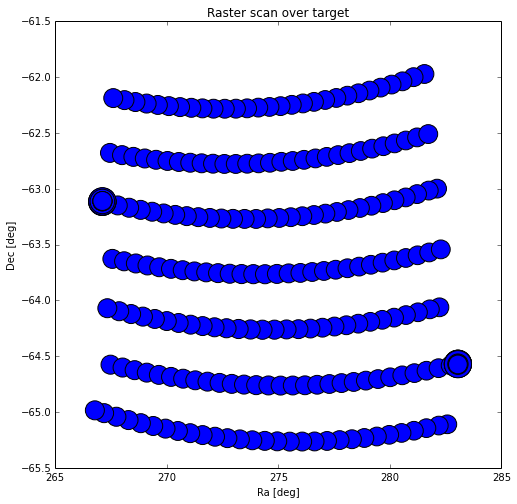

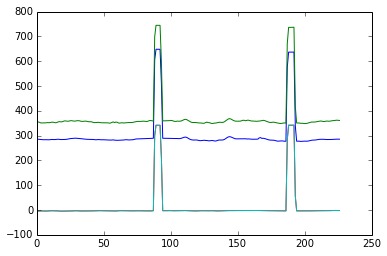

In [12]:
h5file.select(scans='scan')
fig1 = plt.figure(2, figsize=(8,8))
plt.scatter(h5file.ra, h5file.dec, s=np.mean(np.abs(h5file.vis[:,2200:2400,1]), axis=1))
plt.title('Raster scan over target')
plt.ylabel('Dec [deg]')
plt.xlabel('Ra [deg]')

plt.figure()
plt.plot(np.mean(h5file.vis[:,2200:2400,:], axis=1))

#Output and Report

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
# Generate output report
with PdfPages(opts.outfilebase+'.pdf') as pdf:
    out=reduced_data[0]
    offset_az, offset_el = "%.1f" % (60. * out['delta_azimuth'],), "%.1f" % (60. * out['delta_elevation'],)
    beam_width, beam_height = "%.1f" % (60. * out['beam_width_I'],), "%.2f" % (out['beam_height_I'],)
    baseline_height = "%.1f" % (out['baseline_height_I'],)
    pagetext  = "\nCheck Point Source Scan"
    pagetext += "\n\nDescription: %s\nName: %s\nExperiment ID: %s" %(h5file.description, h5file.name, h5file.experiment_id)
    pagetext  = pagetext + "\n"
    pagetext += "\n\nTest Setup:"
    pagetext += "\nRaster Scan across bright source"
    pagetext += "\n\nAntenna %(antenna)s" % out
    pagetext += "\n------------"
    pagetext += ("\nTarget = '%(target)s', azel=(%(azimuth).1f, %(elevation).1f) deg, " % out) +\
                (u"offset=(%s, %s) arcmin" % (offset_az, offset_el))
    pagetext += (u"\nBeam height = %s %s") % (beam_height, out['data_unit'])
    pagetext += (u"\nBeamwidth = %s' (expected %.1f')") % (beam_width, 60. * out['beam_expected_width_I'])
    pagetext += (u"\nHH gain = %.3f Jy/%s") % (out['flux'] / out['beam_height_HH'], out['data_unit'])
    pagetext += (u"\nVV gain = %.3f Jy/%s") % (out['flux'] / out['beam_height_VV'], out['data_unit'])
    pagetext += (u"\nBaseline height = %s %s") % (baseline_height, out['data_unit'])
    pagetext  = pagetext + "\n"
    pagetext += (u"\nMeasured coordinates using rough fit")
    pagetext += (u"\nMeasured AzEl=(%.3f, %.3f) deg" % (measured_delta_az[0], measured_delta_el[0]))
    pagetext  = pagetext + "\n"
    pagetext += (u"\nDetermine new residuals from current pointing model")
    pagetext += (u"\nCurrent model AzEl=(%.3f, %.3f) deg" % (model_delta_az[0], model_delta_el[0]))
    pagetext += (u"\nResidual AzEl=(%.3f, %.3f) deg" % (residual_az[0], residual_el[0]))
    pagetext  = pagetext + "\n"
    pagetext += (u"\nDetermine new residuals from new fit")
    pagetext += (u"\nNew model AzEl=(%.3f, %.3f) deg" % (newmodel_delta_az[0], newmodel_delta_el[0]))
    pagetext += (u"\nResidual AzEl=(%.3f, %.3f) deg" % (residual_az[0], residual_el[0]))
    pagetext  = pagetext + "\n"
    pagetext += (u"\nFitted parameters \n%s" % str(params))

    plt.figure(None,figsize = (16,8))
    plt.axes(frame_on=False)
    plt.xticks([])
    plt.yticks([])
    plt.title("AR1 Report %s"%opts.outfilebase ,fontsize=14, fontweight="bold")
    plt.text(0,0,pagetext,fontsize=12)
    pdf.savefig()
    plt.close()
    pdf.savefig(fig)
    pdf.savefig(fig1)

    d = pdf.infodict()
    import datetime
    d['Title'] = h5file.description
    d['Author'] = 'AR1'
    d['Subject'] = 'AR1 check point source scan'
    d['CreationDate'] = datetime.datetime(2015, 8, 13)
    d['ModDate'] = datetime.datetime.today()